## Mount to gdrive to read data, adjacency matrix, p_link and labels. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Install pandas to read csv files from gdrive. Install torch and numpy which are packages that are needed durind coding.

In [ ]:
!pip install pandas
import pandas as pd
import torch
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load data which are processed in preprocessing_data_4classdes.ipynb file.

In [ ]:
path = F"/gdrive/MyDrive/4classes.sim/data.pt"
Data = torch.load(path)
Data

{'x': tensor([[-0.4530,  0.5955, -1.1069,  ...,  0.5985,  0.1790,  0.2985],
         [ 0.2027,  0.6537,  0.6290,  ..., -0.1876, -1.2782,  0.5982],
         [-0.2713,  0.4418,  1.5845,  ..., -1.1430, -2.2012,  0.7388],
         ...,
         [ 0.5176, -1.6871, -1.4386,  ..., -0.2084,  1.3068, -0.1615],
         [ 0.0700, -1.4413, -0.2656,  ..., -0.3264,  1.0155,  0.4870],
         [-0.2865,  1.4095,  1.7289,  ..., -0.3547, -1.7226,  0.7805]]),
 'edge_index': tensor([[ 0,  0,  1,  1,  1,  2,  2,  2,  2,  4,  4,  4,  4,  5,  5,  6,  6,  6,
           6,  6,  6,  7,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9, 10, 10,
          11, 11, 11, 11, 11, 12, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
          14, 16, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 20, 20, 21, 21, 21, 21,
          21, 21, 22, 23, 24, 24, 24, 24, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26,
          27, 28, 29, 29, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 30, 30, 32, 32,
          33, 34, 34, 34, 34, 34, 34, 35, 36, 3

# Gather some statistics about the graph.

In [ ]:
print(f'Number of nodes: {Data["x"].size(0)}')
print(f'Number of features: {Data["x"].size(1)}')
print(f'Number of classes: {torch.numel(torch.unique(Data["y"],sorted=True))}')
print(f'Number of edges: {Data["edge_index"].size(1)}')
print(f'Average node degree: {Data["edge_index"].size(1) / Data["x"].size(0):.2f}')
print(f'Number of training nodes: {Data["train_mask"].sum()}')
print(f'Number of testing nodes: {Data["test_mask"].sum()}')
print(f'Training node label rate: {int(Data["train_mask"].sum()) /  Data["x"].size(0):.2f}')

Number of nodes: 40
Number of features: 500
Number of classes: 4
Number of edges: 126
Average node degree: 3.15
Number of training nodes: 8
Number of testing nodes: 22
Training node label rate: 0.20


# Read p_link from gdrive to use it as the attention.

In [ ]:
path = F"/gdrive/MyDrive/4classes.sim/p_link.pt"
p_link = torch.load(path)
print(p_link)
print(p_link.size())
print(p_link.dtype)
print(p_link.type())

tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0200, 0.0900, 0.0000],
        [0.0000, 1.0000, 0.2000,  ..., 0.6900, 0.0200, 0.2100],
        [0.0000, 0.2000, 1.0000,  ..., 0.0300, 0.0300, 0.0100],
        ...,
        [0.0200, 0.6900, 0.0300,  ..., 1.0000, 0.1600, 0.5800],
        [0.0900, 0.0200, 0.0300,  ..., 0.1600, 1.0000, 0.2000],
        [0.0000, 0.2100, 0.0100,  ..., 0.5800, 0.2000, 1.0000]])
torch.Size([40, 40])
torch.float32
torch.FloatTensor


# Install torch_geometic.

In [ ]:
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116
     |████████████████████████████████| 9.4 MB 6.6 MB/s 
     |████████████████████████████████| 4.6 MB 9.3 MB/s 
     |████████████████████████████████| 280 kB 7.1 MB/s 


# Developing our own model (making our own message passing layers).

# BGATConv
$$ X^\prime _i = \sum_{j \in N(i)\cup i} \alpha_{ij}\Theta X_j$$
In which $\alpha$s are computed via BDgraph(p_link) and $\Theta$ is learnable parameter.

In [ ]:
import torch_geometric
from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.utils import add_self_loops

# Creating message passing network.

In [ ]:
class BGATConv(MessagePassing):
    def __init__(
        self,
        in_channels,
        out_channels,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim = 0, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        edge_index, _ = add_self_loops(Data["edge_index"], num_nodes = Data["x"].size(0))
        x = self.lin(x)
        atten = p_link
        return self.propagate(edge_index, x = x, atten = atten)

    def message(self, x_j, atten, edge_index_i, edge_index_j):
        return atten[edge_index_i, edge_index_j].reshape(-1,1) * x_j

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels, self.out_channels)

# Make GNN layers with our own model, BGAT. We use three BGAT conv.

In [ ]:
class Myconv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(2)
        self.conv1 = BGATConv(in_channels = 500, out_channels = 50)
        self.conv2 =  BGATConv(50,10)
        self.conv3 =  BGATConv(10, 4)
        
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = F.torch.tanh(h)
        h = self.conv2(h, edge_index)
        h = F.torch.tanh(h)
        h = self.conv3(h, edge_index)# Final GNN embedding space.
        h = F.log_softmax(h)
        return h
        
model = Myconv()
print(model)
print(model.forward(Data["x"], Data["edge_index"]))

Myconv(
  (conv1): BGATConv(500, 50)
  (conv2): BGATConv(50, 10)
  (conv3): BGATConv(10, 4)
)
tensor([[ -2.8707,  -3.4974,  -0.1526,  -2.9075],
        [ -1.0652,  -1.9093,  -1.5955,  -1.1896],
        [ -2.1635,  -3.3861,  -0.3989,  -1.7140],
        [ -1.3228,  -1.4786,  -1.5151,  -1.2521],
        [ -2.0014,  -0.6609,  -1.0544,  -9.5835],
        [ -2.0046,  -2.8759,  -0.6233,  -1.2992],
        [ -2.8296,  -0.2859,  -1.6626, -12.7543],
        [ -1.1789,  -1.5411,  -1.6864,  -1.2275],
        [ -2.8913,  -0.2720,  -1.7003, -13.0820],
        [ -2.4686,  -0.4631,  -1.2520, -11.6449],
        [ -1.4750,  -1.7880,  -0.9600,  -1.5094],
        [ -0.9170,  -1.2654,  -1.9920,  -1.7053],
        [ -1.4784,  -2.0022,  -0.9031,  -1.4624],
        [ -2.7180,  -2.9736,  -0.2210,  -2.5118],
        [ -2.8403,  -0.2415,  -1.8570, -14.6291],
        [ -1.3367,  -1.5211,  -1.3278,  -1.3714],
        [ -1.6430,  -2.3355,  -0.8739,  -1.2291],
        [ -3.4319,  -4.1346,  -0.0958,  -3.1470],
      

<ipython-input-9-1380e3f952d9>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


# We take a look at the node embeddings produced by our GNN (before training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(z[:, 0], z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",4)).set(title = "First scenario data T-SNE projection before training (BGAT)")

<ipython-input-9-1380e3f952d9>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Embedding shape: [40, 4]


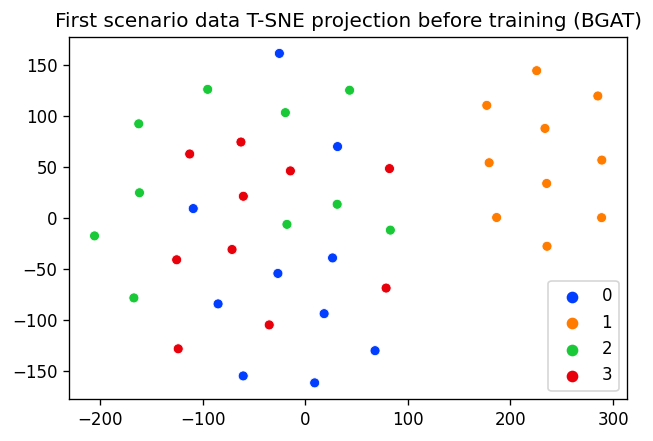

In [ ]:
model = Myconv()
h = model(Data["x"], Data["edge_index"])

print(f'Embedding shape: {list(h.shape)}')
visualize(h)

# Start training the model. 

In [ ]:
model = Myconv()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),  lr = 0.0005)  # Define optimizer, an object for updating parameters
#loss = loss + weight decay parameter * L2 norm of the weights, 1) To prevent overfitting 2) To keep the weights small and avoid exploding gradient

def train(Data):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(Data["x"], Data["edge_index"])
    train_loss = criterion(out[Data["train_mask"]], Data["y"][Data["train_mask"]])  # Compute the loss solely based on the training nodes.
    train_loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return train_loss


def val(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        val_loss = criterion(out[Data["val_mask"]], Data["y"][Data["val_mask"]])
        #pred = out.argmax(dim=1)
        #test_correct = pred[Data["val_mask"]] == Data["y"][Data["val_mask"]]  # Check against ground-truth labels.
        #test_acc = int(test_correct.sum()) / int(Data["val_mask"].sum())  # Derive ratio of correct predictions.
        return val_loss


In [ ]:
train_loss_ = []
val_loss_ = []

for epoch in range(1, 201):

  epoch_train_loss = []
  epoch_val_loss = []
  train_loss = train(Data)
  val_loss = val(Data)






  epoch_train_loss.append(train_loss.item())
  epoch_val_loss.append(val_loss.item())




  

  val_loss_.append(sum(epoch_val_loss)/len(epoch_val_loss))
  train_loss_.append(sum(epoch_train_loss)/len(epoch_train_loss))
  print(epoch,'Train Loss: %.3f | val Loss: %.3f'%( train_loss,val_loss))

<ipython-input-9-1380e3f952d9>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


1 Train Loss: 1.478 | val Loss: 1.093
2 Train Loss: 0.957 | val Loss: 0.872
3 Train Loss: 0.624 | val Loss: 0.717
4 Train Loss: 0.415 | val Loss: 0.609
5 Train Loss: 0.288 | val Loss: 0.545
6 Train Loss: 0.214 | val Loss: 0.509
7 Train Loss: 0.169 | val Loss: 0.485
8 Train Loss: 0.141 | val Loss: 0.469
9 Train Loss: 0.121 | val Loss: 0.456
10 Train Loss: 0.107 | val Loss: 0.446
11 Train Loss: 0.096 | val Loss: 0.439
12 Train Loss: 0.087 | val Loss: 0.432
13 Train Loss: 0.080 | val Loss: 0.427
14 Train Loss: 0.074 | val Loss: 0.423
15 Train Loss: 0.069 | val Loss: 0.419
16 Train Loss: 0.064 | val Loss: 0.416
17 Train Loss: 0.060 | val Loss: 0.414
18 Train Loss: 0.057 | val Loss: 0.412
19 Train Loss: 0.054 | val Loss: 0.410
20 Train Loss: 0.051 | val Loss: 0.409
21 Train Loss: 0.049 | val Loss: 0.407
22 Train Loss: 0.047 | val Loss: 0.406
23 Train Loss: 0.045 | val Loss: 0.405
24 Train Loss: 0.044 | val Loss: 0.404
25 Train Loss: 0.043 | val Loss: 0.403
26 Train Loss: 0.042 | val Loss: 0

# Visualize train loss and val loss.


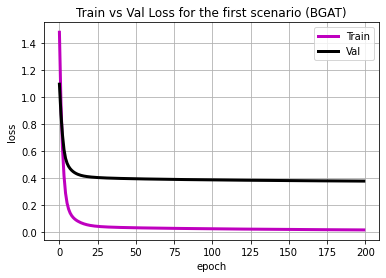

In [ ]:
plt.plot(train_loss_, "m", linewidth = 3)
plt.plot(val_loss_, "k", linewidth = 3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Val'])
plt.title('Train vs Val Loss for the first scenario (BGAT)')
plt.grid()
plt.show()

# Compute the accuracy of the model.

In [ ]:
def test(Data):
      model.eval()
      with torch.no_grad():
        out = model(Data["x"], Data["edge_index"])
        pred = out.argmax(dim = 1)
        test_correct = pred[Data["test_mask"]] == Data["y"][Data["test_mask"]]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(Data["test_mask"].sum())  # Derive ratio of correct predictions.
        return test_acc


In [ ]:
test_acc = test(Data)
print(f'Test Accuracy: {100*test_acc:.2f}')

Test Accuracy: 90.91


<ipython-input-9-1380e3f952d9>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)


# We take a look at the node embeddings produced by our GNN (after training).

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

def visualize(h):
    z = TSNE(n_components = 2, random_state = 0).fit_transform(h.detach().numpy())
    plt.figure(figsize = (6,4),  dpi = 120)
    sns.scatterplot(z[:, 0], z[:, 1], hue = Data["y"], palette=sns.color_palette("bright",4)).set(title = "First scenario data T-SNE projection after training (BGAT)")

<ipython-input-9-1380e3f952d9>:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  h = F.log_softmax(h)
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


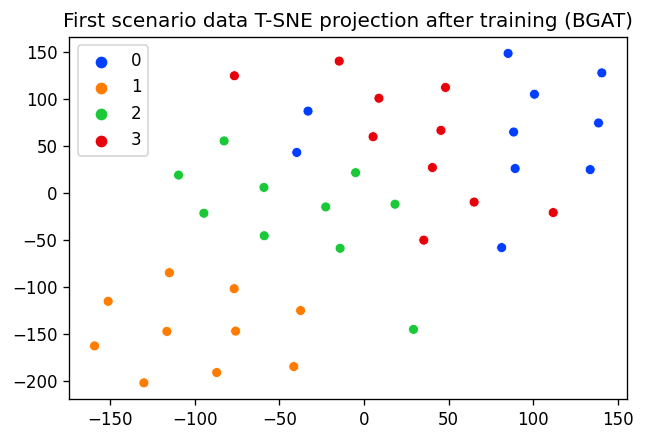

In [ ]:
model.eval()
out = model(Data["x"], Data["edge_index"])
visualize(out)

# Confusion matrix.

In [ ]:
pred = out.argmax(dim=1)
pred

tensor([0, 2, 3, 3, 1, 3, 1, 3, 1, 1, 3, 2, 3, 0, 1, 2, 3, 0, 2, 2, 0, 1, 0, 3,
        1, 3, 2, 2, 2, 1, 1, 3, 2, 0, 1, 2, 3, 2, 2, 0])

In [ ]:
pred = pred[Data["test_mask"]] 

In [ ]:
act = Data["y"][Data["test_mask"]]

In [ ]:
data = {'y_Actual':    act,
        'y_Predicted': pred
        }

df = pd.DataFrame(data, columns = ['y_Actual','y_Predicted'])
df

,y_Actual,y_Predicted
0,2,2
1,3,3
2,0,3
3,1,1
4,1,1
5,3,3
6,0,0
7,3,3
8,0,0
9,2,2


<ipython-input-23-0008894d1f6a>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


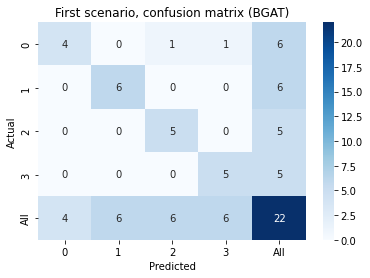

In [ ]:
confusion_matrix = pd.crosstab(data['y_Actual'], data['y_Predicted'], rownames=['Actual'], colnames = ['Predicted'], margins = True)
import seaborn as sn
sn.heatmap(confusion_matrix, annot=True,  cmap="Blues")
ax = plt.axes()
ax.set_title('First scenario, confusion matrix (BGAT)')
plt.show()